In [655]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Load data files
import numpy as np
import urllib.request
import io



In [656]:
import torch
import sklearn.datasets

In [657]:
from timeit import default_timer as timer

In [658]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [659]:
n_classes = 2

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=5,
                                            n_informative=5,
                                            n_redundant=0,
                                            n_repeated=0,
                                            class_sep=0.5,
                                            n_classes=n_classes,
                                            random_state = 4)

n_features = X.shape[1]

In [660]:
# transform labels
y = np.where(y == 0, -1, y)

In [661]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 800 200


# Clipping and Gradient definition

In [662]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [663]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    clipped_grads = L2_clip_array(gradients, C)
    return np.sum(clipped_grads, axis = 0)

In [748]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# Baseline (gradient clipping DP-SGD)

In [749]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grad_sum        = vgradient(theta, xs, ys, clipping_param)
            noisy_grad_sum  = gaussian_mech_zCDP_vec(grad_sum, clipping_param, rho_i)
            noisy_avg_grad  = noisy_grad_sum / BATCH_SIZE
            theta           = theta - noisy_avg_grad

    return theta

In [750]:
rho = 0.01
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.6886140424415113
mean: 0.7605000000000001
std: 0.009861541461658019


# Calvin's Sensitivity Implementation

In [923]:
def compute_sens_torch(many_xs, t, m, a, b, device):
    # Clamp and sort all xs's at once, assuming shape is (num_iter, n)
    many_xs = many_xs.clamp(a, b).sort(dim=1).values
    n = many_xs.size(1)
    assert n - 2*m > 0, f'm = {m} and n = {n} means n - 2m = {n-2*m} is negative'

    num_iter = many_xs.size(0)

    # Concat [b, a] to the end of every xs so that indexing -1 gives a and indexing n gives b, then clamp indices to -1, n
    fa = torch.full((num_iter, 1), b, dtype=torch.double, device=device)
    fb = torch.full((num_iter, 1), a, dtype=torch.double, device=device)
    many_xs = torch.cat((many_xs, fa, fb), dim=1)

    # Generate indices now so they don't need to be every time (will be xs[idx1] - xs[idx2]), this doesn't need to be efficient but w/e
    ks = torch.arange(0, n+1, device=device) # distances
    #ks = torch.arange(0, 5, device=device) # distances
    ls = torch.arange(0, n+2, device=device)
    # Use all l values then take lower triangular part of matrix plus (with diagonal shifted by one) to remove values where l > k+1
    idx1 = torch.tril(n - m + 1 + ks.reshape(-1, 1) - ls, diagonal=1).clamp(-1, n)
    idx2 = (m + 1 - ls).clamp(-1, n)

    scalar = torch.exp(-1 * ks * t)

    out = torch.empty(num_iter)
    out2 = torch.empty(num_iter)
    for i in range(num_iter):
        xs = many_xs[i]

        diffs = torch.tril(torch.abs(xs[idx1] - xs[idx2]), diagonal=1)
        inner_max = diffs.max(dim=1).values
        #print('inner_max:', inner_max[20])
        outer_max = (inner_max*scalar).max()
        out[i] = outer_max / (n - 2*m)
        out2[i] = inner_max[50]

    #print('l2:', )
    return out, np.linalg.norm(out2.numpy(), ord=2)


# Smooth Sensitivity DP-SGD

In [924]:
def lln(sigma, size):
    x = np.random.laplace(size=size)
    y = np.random.normal(size=size)
    return x * np.exp(sigma * y)

In [925]:
def vgradient_per_ex(theta, x, y):
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients

def smooth_dp_gradient_descent(epochs, rho, 
                               upper=1, lower=-1,
                               m=30, t=0.001):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy
    
    BATCH_SIZE = 256

    rho_weight = rho_i / X_train.shape[1]
    #print('target per-weight rho:', rho_weight)

    sigma, s = optimize_sigma(rho_weight, t)    
    #print('sigma:', sigma, 's:', s)

    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)
    batches_X = [X]
    batches_y = [y]
    
    actual_batch_size = len(batches_X[0])
    print('actual batch size:', actual_batch_size)
    print('global sens:', 1/actual_batch_size)
    
    for i in range(epochs):
        for xs, ys in zip(batches_X, batches_y):
            cx = xs#L2_clip_array(xs, epochs/2)
            gradients       = vgradient_per_ex(theta, cx, ys)
            noisy_avg_grad  = trimmed_mean(gradients, t, m, lower, upper, sigma, s)
            theta           = theta - noisy_avg_grad

    return theta

In [933]:
# Compute the trimmed mean
def trimmed_mean(many_xs, t, m, a, b, sigma, s):
    clipped_xs = np.sort(many_xs.clip(a, b), axis=0)
    n = clipped_xs.shape[0]
    trimmed_xs = clipped_xs[m:n-m]
    width = clipped_xs.shape[1]
    diffs = clipped_xs[n-m] - clipped_xs[m]
    #print('diffs:', diffs)
    
    many_xs_torch = torch.from_numpy(clipped_xs)

    sens, l2_sens_20 = compute_sens_torch(many_xs_torch.T, t, m, a, b, 'cpu')
    #print('sens:', sens)
    #noise = torch.tensor(lln(sigma, width))
    delta = 1e-5/10
    epsilon = .05
    real_sens = l2_sens_20 / (n - 2*m)
    print('real sens:', real_sens, 'n:', n, 'prescale:', l2_sens_20)
    g_sigma = np.sqrt(2*(real_sens**2)*np.log(1.25/delta) / (epsilon**2))
    noise = np.random.normal(loc=0, scale=g_sigma, size=width)
    return np.mean(trimmed_xs, axis=0) + noise #((sens/s)*noise).numpy()


In [934]:
def opt_exp(eps, t, sigma):
    return 5 * (eps / t) * sigma**3 - 5 * sigma**2 - 1

def optimize_sigma(target_rho, t):
    target_eps = np.sqrt(2*target_rho)
    sigma_lower = t / target_eps
    sigma_upper = max(2*t / target_eps, 1/2)
    
    loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))
    while np.abs(loss) > 0.001:
        #print('loss:', loss)
        if loss < 0:
            sigma_lower = np.mean([sigma_lower, sigma_upper])
        else:
            sigma_upper = np.mean([sigma_lower, sigma_upper])

        loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))

    sigma = np.mean([sigma_lower, sigma_upper])
    s = np.exp(-(3/2) * sigma**2) * (target_eps - (t / sigma))

    return sigma, s

In [944]:
%%time
#np.set_printoptions(threshold=20)
accuracy(smooth_dp_gradient_descent(20, 1, t=0.01, m=200))

actual batch size: 1000
global sens: 0.001
real sens: 0.004810291528701782 n: 1000 prescale: 2.886175
real sens: 0.004474966526031494 n: 1000 prescale: 2.68498
real sens: 0.0040030133724212645 n: 1000 prescale: 2.401808
real sens: 0.004029638369878133 n: 1000 prescale: 2.417783
real sens: 0.004460937182108562 n: 1000 prescale: 2.6765623
real sens: 0.005094389120737712 n: 1000 prescale: 3.0566335
real sens: 0.004459748268127442 n: 1000 prescale: 2.675849
real sens: 0.004255106449127197 n: 1000 prescale: 2.5530639
real sens: 0.003874603509902954 n: 1000 prescale: 2.324762
real sens: 0.0038270088036855064 n: 1000 prescale: 2.2962053
real sens: 0.004107257127761841 n: 1000 prescale: 2.4643543
real sens: 0.0037656656901041666 n: 1000 prescale: 2.2593994
real sens: 0.003287147283554077 n: 1000 prescale: 1.9722884
real sens: 0.003686331510543823 n: 1000 prescale: 2.211799
real sens: 0.0036925212542215985 n: 1000 prescale: 2.2155128
real sens: 0.003712547222773234 n: 1000 prescale: 2.2275283
r

0.61

In [936]:
zcdp_eps(0.001, 1e-5)

0.21559660262893474

In [496]:
rho = .01
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(smooth_dp_gradient_descent(epochs, rho, t=0.0001)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.6886140424415113
mean: 0.6485000000000001
std: 0.06016851336039474


In [497]:
ms = np.linspace(1, 60, 10)
rho = 0.1

all_accs = []
all_stds = []

for m in ms:
    accs = [accuracy(smooth_dp_gradient_descent(epochs, rho, t=0.01, m=int(m))) for _ in range(40)]
    all_accs.append(np.mean(accs))
    all_stds.append(np.std(accs))

<ErrorbarContainer object of 3 artists>

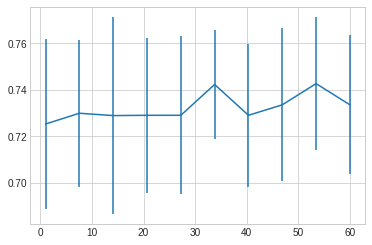

In [498]:
plt.errorbar(ms, all_accs, yerr=all_stds)

In [501]:
ts = [float(10**-i) for i in range(1, 10)]
rho = .1
m=30

all_accs = []
all_stds = []

for t in ts:
    accs = [accuracy(smooth_dp_gradient_descent(epochs, rho, t=t, m=int(m))) for _ in range(10)]
    all_accs.append(np.mean(accs))
    all_stds.append(np.std(accs))

/home/jnear/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


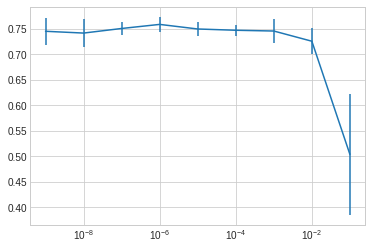

In [502]:
plt.errorbar(ts, all_accs, yerr=all_stds)
plt.xscale('log');